<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_5%5DClassifying_by_rock%2C_paper%2C_scissor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import glob
import os
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


## 함수 만들기

### 1) 이미지 사이즈 변환

In [2]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

### 2) load train data

In [3]:
def load_data(img_path, number_of_data):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

## 3. 이미지 사이즈 변환하기

In [4]:
# train_scissor
train_scissor_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/scissor"
resize_images(train_scissor_image_dir_path)

# train_rock
train_rock_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/rock"
resize_images(train_rock_image_dir_path)

# train_paper
train_paper_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/paper"
resize_images(train_paper_image_dir_path)

# test_scissor
test_scissor_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/test/scissor"
resize_images(test_scissor_image_dir_path)

# test_rock
test_rock_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/test/rock"
resize_images(test_rock_image_dir_path)

# test_paper
test_paper_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/test/paper"
resize_images(test_paper_image_dir_path)

500  images to be resized.
500  images resized.
500  images to be resized.
500  images resized.
500  images to be resized.
500  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


## 4. train, test 데이터셋 불러오기 및 정규화

### 1) train

In [5]:
train_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper"
(x_train, y_train)=load_data(train_image_dir_path,number_of_data=1500)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

학습데이터(x_train)의 이미지 개수는 1500 입니다.


In [6]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (1500, 28, 28, 3)
y_train shape: (1500,)


### 2) test

In [7]:
test_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/test"
(x_test, y_test)=load_data(test_image_dir_path,number_of_data=300)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

학습데이터(x_train)의 이미지 개수는 300 입니다.


In [8]:
print("x_train shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_test.shape))

x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


## 5. 딥러닝 네트워크 설계

In [9]:

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (N

## 6. 딥러닝 학습

In [10]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
             
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
47/47 [==============================] - 2s 31ms/step - loss: 3.8793 - accuracy: 0.5260
Epoch 2/10
47/47 [==============================] - 1s 31ms/step - loss: 0.4401 - accuracy: 0.8133
Epoch 3/10
47/47 [==============================] - 1s 31ms/step - loss: 0.2563 - accuracy: 0.8913
Epoch 4/10
47/47 [==============================] - 2s 32ms/step - loss: 0.1994 - accuracy: 0.9060
Epoch 5/10
47/47 [==============================] - 1s 31ms/step - loss: 0.1203 - accuracy: 0.9500
Epoch 6/10
47/47 [==============================] - 2s 32ms/step - loss: 0.0899 - accuracy: 0.9633
Epoch 7/10
47/47 [==============================] - 1s 31ms/step - loss: 0.0514 - accuracy: 0.9847
Epoch 8/10
47/47 [==============================] - 1s 31ms/step - loss: 0.0356 - accuracy: 0.9920
Epoch 9/10
47/47 [==============================] - 1s 31ms/step - loss: 0.0187 - accuracy: 0.9987
Epoch 10/10
47/47 [==============================] - 1s 31ms/step - loss: 0.0322 - accuracy: 0.9893


In [11]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 2.7238 - accuracy: 0.6600 - 221ms/epoch - 22ms/step
test_loss: 2.723830461502075 
test_accuracy: 0.6600000262260437


## 7. 어떤 데이터를 잘못 추론 했는지 확인

In [12]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

예측확률분포: [2.2410133e-05 4.0794043e-03 9.9589819e-01]
라벨: 0, 예측결과: 2


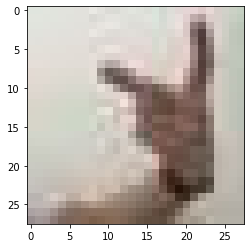

예측확률분포: [8.6295294e-08 5.8547924e-03 9.9414510e-01]
라벨: 0, 예측결과: 2


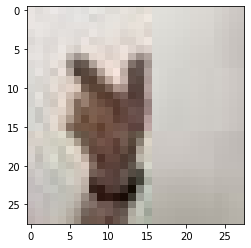

예측확률분포: [9.9999988e-01 2.5624058e-11 1.7384501e-07]
라벨: 2, 예측결과: 0


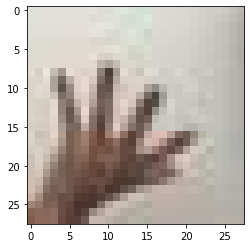

예측확률분포: [0.00150395 0.954672   0.0438241 ]
라벨: 0, 예측결과: 1


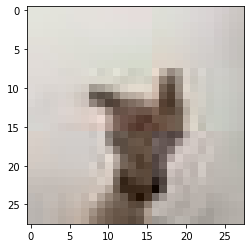

예측확률분포: [0.9766891  0.00470856 0.01860236]
라벨: 2, 예측결과: 0


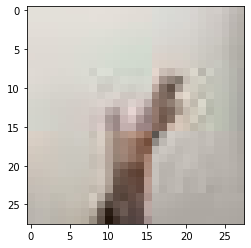

In [13]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()